In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from umap import UMAP
from sklearn.metrics import pairwise_distances

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [4]:
sns.set(font_scale=1.25, style="ticks", context="notebook", palette="tab10")

In [5]:
## create mouse map
nage=6 #number of age groups
nmice=16
keep_mice = [
    "_01_01",
    "_01_02",
    "_01_03",
    "_01_04",
    "_02_01",
    "_02_02",
    "_02_03",
    "_02_04",
    "_03_01",
    "_03_02",
    "_03_03",
    "_03_04",
    "_04_01",
    "_04_02",
    "_04_03",
    "_04_04",
] * nage
ages = np.repeat(['4','8','12','52','78','90'],nmice)
mouse_id = [x + y for x, y in zip(ages, keep_mice)]
samples = list(range(1,nage*nmice+1))
mapping = {key: value for key, value in zip(samples, mouse_id)}

In [6]:
## upload the raw beta file and sample table and ID

In [7]:
base_folder = Path("/n/groups/datta/win/longtogeny/data/epigenetics/analysis")

In [8]:
df_sample_mean = pd.read_csv(
    "/n/groups/datta/win/longtogeny/data/epigenetics/Datta_Project_001/Datta_Project_001/Datta_Project_001_Samples_Table.txt", sep="\t"
)

In [9]:
df = pd.read_csv(
    "/n/groups/datta/win/longtogeny/data/epigenetics/Datta_Project_001/Datta_Project_001/Datta_Project_001_Sample_Methylation_Profile.txt", sep="\t"
)

In [10]:
df["target_type"] = df.TargetID.str[:2]
df_subset = df[df.target_type == "cg"].copy()

# uploads normalized and corrected betas from sesame script in R

In [11]:
# opload prediction of age from epigenetic clock zou 2022 as applied by sesame
df_age_pred = pd.read_csv(base_folder / "age_prediction.csv", index_col=0)
df_age_pred["weeks"] = df_age_pred["outs"] * 4
weeks = [4, 8, 12, 52, 78, 90]
array_week = np.array(weeks)

In [12]:
# upload normzlized and corrected beta values as calculated by r script sesame
df_beta = pd.read_csv(base_folder / "betas_mat.csv.gz", index_col=0)

In [13]:
# arrange data and run PCA
df_keep = df_beta[~df_beta.isnull().any(axis=1)]
X_mat = df_keep.values.T
print(X_mat.shape)

pca = PCA(n_components=20).fit(X_mat)
X_pca = pca.transform(X_mat)

(24, 275573)


In [14]:
#seperate the array name from the raw-column id. to be used later to map location on chip to mouse id
df_meta = pd.DataFrame(
    df_keep.columns.str.split("_").tolist(),
    columns=["array", "rc"],
    index=df_keep.columns,
)

In [15]:
# to map mouse id to location on plate
df_sample_mean.columns = df_sample_mean.columns.map(lambda l: l.replace(" ", "_"))
df_sample_mean["array"] = df_sample_mean["Sentrix_Barcode"].astype(str).copy()

In [16]:
# match mouse/sampel id to array location, add chronolocal age information
# df_meta_merge matches sample id with all kinds of meta data such as chip. r-c location and intensity measures.  
df_meta_merge = (
    df_meta.reset_index()
    .merge(
        df_sample_mean,
        left_on=["array", "rc"],
        right_on=["array", "Sample_Section"],
        how="left",
    )
    .set_index("index")
)
df_meta_merge["age"] = array_week[
    np.floor(((df_meta_merge["Index"] - 1) / 4)).astype(int)
]
df_meta_merge["age_cat"] = pd.Categorical(df_meta_merge.age, categories=weeks)

assert df_keep.columns.equals(df_meta_merge.index)

In [17]:
## add mouse identification to df_meta_merge
df_meta_merge['mouse_id'] = df_meta_merge['Sample_ID']
df_meta_merge['mouse_id'] = df_meta_merge['mouse_id'].map(mapping)
dna_meta = df_meta_merge[['age','mouse_id']]

In [18]:
temp = df_keep.T
dna_x = dna_meta.merge(temp,left_index=True, right_index=True)
dna_x.set_index(['age','mouse_id'], drop=True, inplace=True)

In [19]:
## regression

In [20]:
#prepare data
data=dna_x.copy()
y =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()

In [21]:
## choose a model for decoder
#clf = KNeighborsRegressor(n_neighbors=10)
clf= Lasso(alpha=0.1)
#clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 100)
#clf = LinearRegression()
# choose cross validation scheme
cv = LeaveOneOut()
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
#number of iterations for shuffle
it=1000

In [22]:
#decoder
y_pred = cross_val_predict(clf, X, y, cv=cv)
r2_age = r2_score(y, y_pred)
print(r2_age)

0.9624109561141027


## explore fit

In [23]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

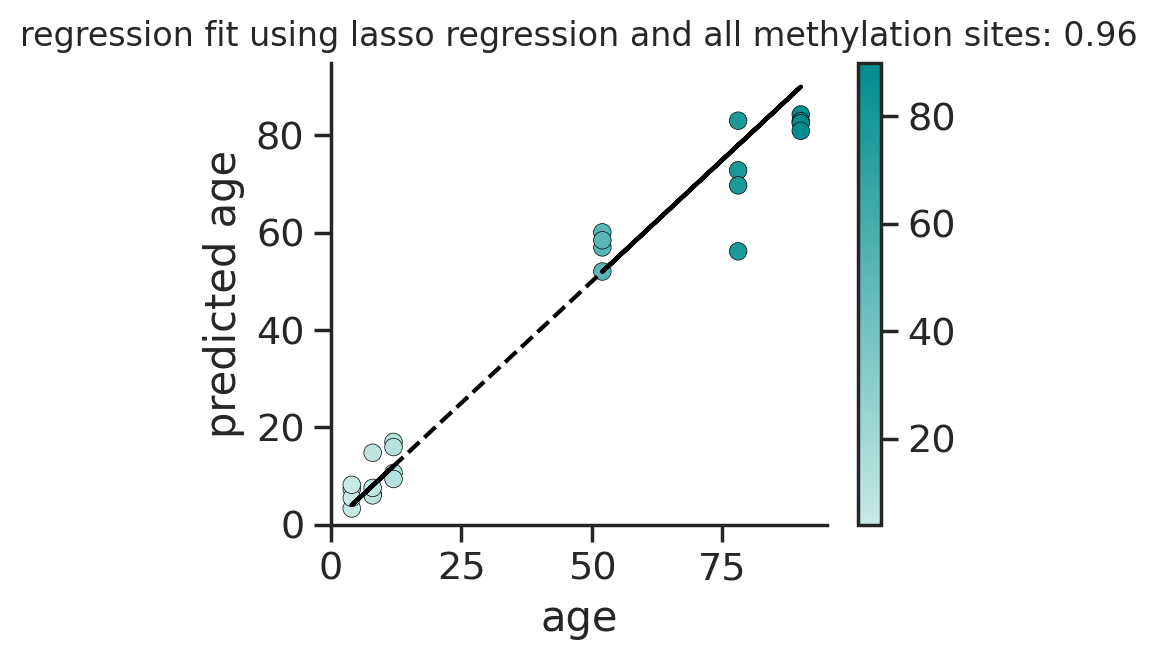

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y, y=y_pred, 
            s=40, 
            c=y, 
            edgecolor='black',
            linewidth=0.25,
            #norm='log',
            cmap=cmm)
sns.despine()
norm = plt.Normalize(y.min(), y.max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])
plt.ylim([0, 95])
plt.xlim([0, 95])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.title('regression fit using lasso regression and all methylation sites: '+ str(round(r2_age, 2)), fontsize=12)
plt.plot(y, y, linestyle='--', color='black')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

## explore robustness

In [25]:
## get all the coefs for the kfolds to compare robustness
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
y_coefs = cross_validate(clf, X, y, cv=cv, scoring='r2', return_estimator=True)
coefs = np.array([clf.coef_ for clf in y_coefs['estimator']])

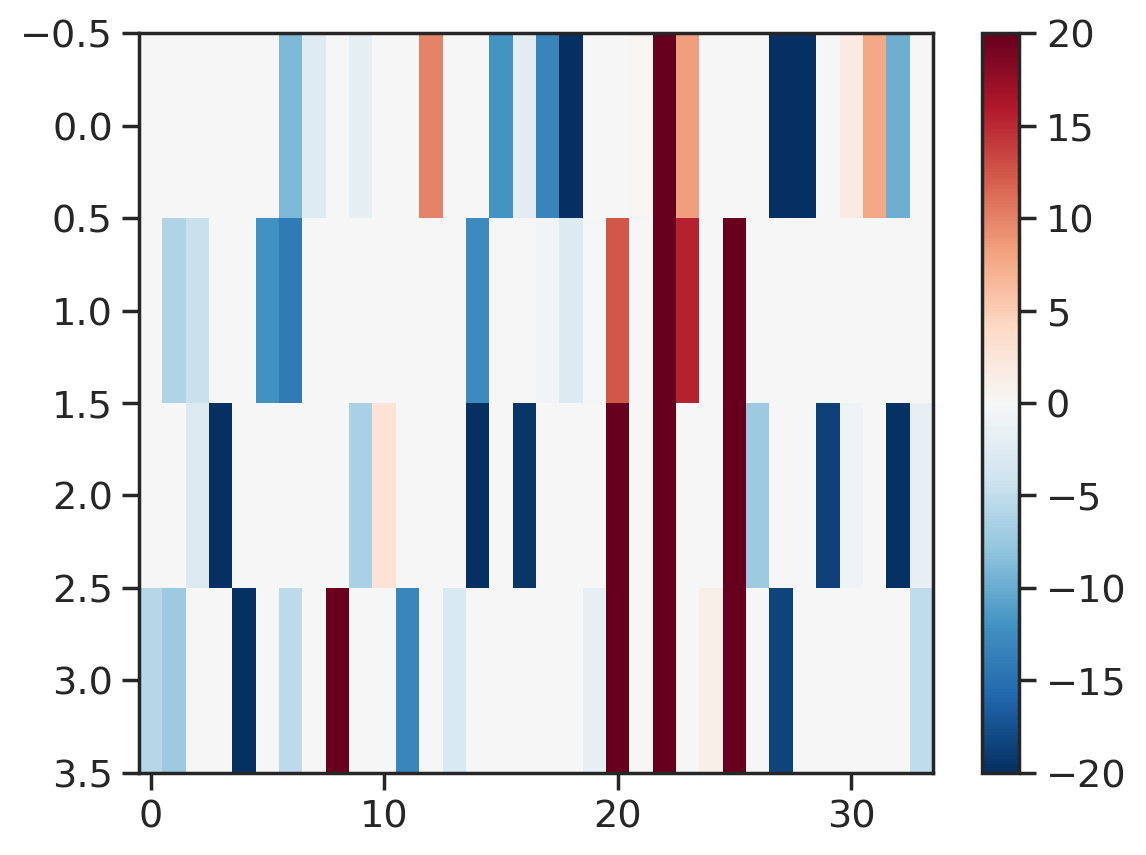

In [26]:
mask = np.any(coefs != 0, axis=0)
plt.imshow(coefs[:, mask], aspect='auto', interpolation='none', cmap='RdBu_r', vmin=-20, vmax=20)
plt.colorbar()

In [27]:
print('number of sites per fold: ', np.count_nonzero(coefs[:, mask], axis=1))

number of sites per fold:  [16 13 14 14]


In [28]:
print('fit of model per fold: ',y_coefs['test_score'])

fit of model per fold:  [0.9171149  0.97402594 0.98575406 0.97274893]


In [29]:
## resample multiple fits to get some estimation of robustness

In [30]:
## get all the coefs for the kfolds to compare robustness
from tqdm import tqdm
it=5
models=[]
coefs=[]
for i in tqdm(range(it)):
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    y_coefs = cross_validate(clf, X, y, cv=cv, scoring='r2', return_estimator=True)
    models.append(y_coefs)
    temp_coefs = np.array([clf.coef_ for clf in y_coefs['estimator']])
    coefs.append(temp_coefs)
    mask = np.any(temp_coefs != 0, axis=0)
    print('number of sites per fold: ', np.count_nonzero(temp_coefs[:, mask], axis=1))
    print('fit of model per fold: ',y_coefs['test_score'])

 20%|██████████████████████████████████▏                                                                                                                                        | 1/5 [00:35<02:23, 35.85s/it]

number of sites per fold:  [16 13 14 14]
fit of model per fold:  [0.9171149  0.97402594 0.98575406 0.97274893]


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 2/5 [01:11<01:47, 35.86s/it]

number of sites per fold:  [11 14 14 16]
fit of model per fold:  [0.9771861  0.91144673 0.94569518 0.97758166]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3/5 [01:47<01:11, 35.89s/it]

number of sites per fold:  [15 13 13 16]
fit of model per fold:  [0.97882941 0.99189481 0.97156588 0.91978545]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4/5 [02:25<00:36, 36.86s/it]

number of sites per fold:  [14 15 14 18]
fit of model per fold:  [0.98691324 0.93815377 0.97770799 0.98141385]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:04<00:00, 36.83s/it]

number of sites per fold:  [15 15 14 13]
fit of model per fold:  [0.97327105 0.96924499 0.99613282 0.93915395]


In [31]:
## plot for all iterations

In [32]:
arr=np.array(coefs)
arr = arr.reshape(-1, arr.shape[-1])

Text(0.5, 1.0, 'coefs of methylaiton sites of lasso regression > 0 at any iteration')

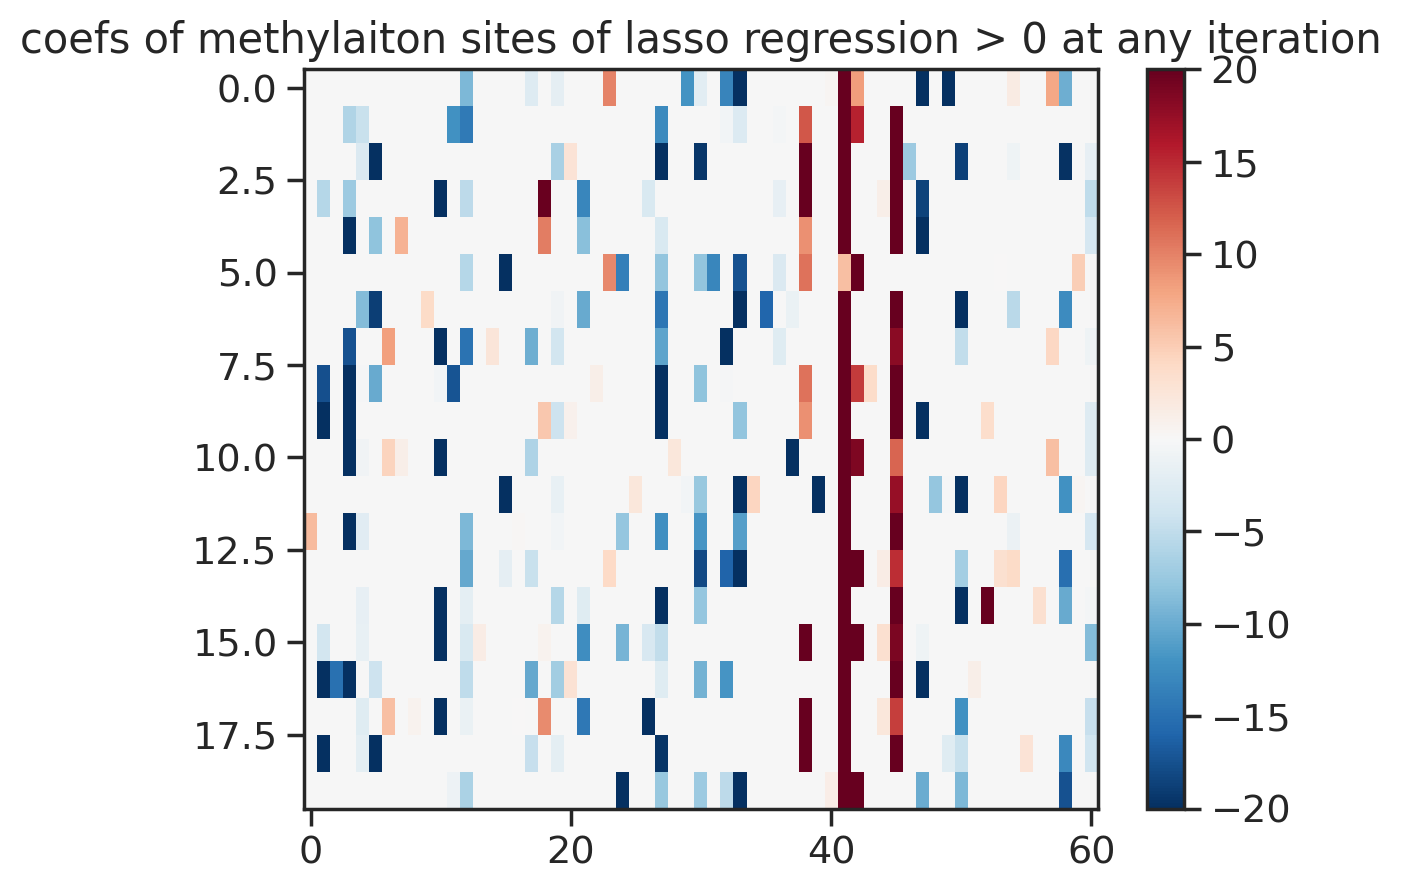

In [33]:
mask = np.any(arr != 0, axis=0)
plt.imshow(arr[:, mask], aspect='auto', interpolation='none', cmap='RdBu_r', vmin=-20, vmax=20)
plt.colorbar()
plt.title ('coefs of methylaiton sites of lasso regression > 0 at any iteration')

In [34]:
## take the epi sites and used them as selected featured for regression

In [35]:
# take all sites with no zero coefficients over all folds
mask = np.any(arr != 0, axis=0)
fX = X[:,mask]

In [36]:
## use regular linear regression to predict chronological age just using these sites

In [37]:
## choose a model for decoder
#clf = KNeighborsRegressor(n_neighbors=10)
#clf= Lasso(alpha=0.1)
#clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 100)
clf = LinearRegression()
# choose cross validation scheme
cv = LeaveOneOut()
#cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [38]:
#decoder
y_pred = cross_val_predict(clf, fX, y, cv=cv)
r2_age = r2_score(y, y_pred)
print(r2_age)

0.9871358744711949


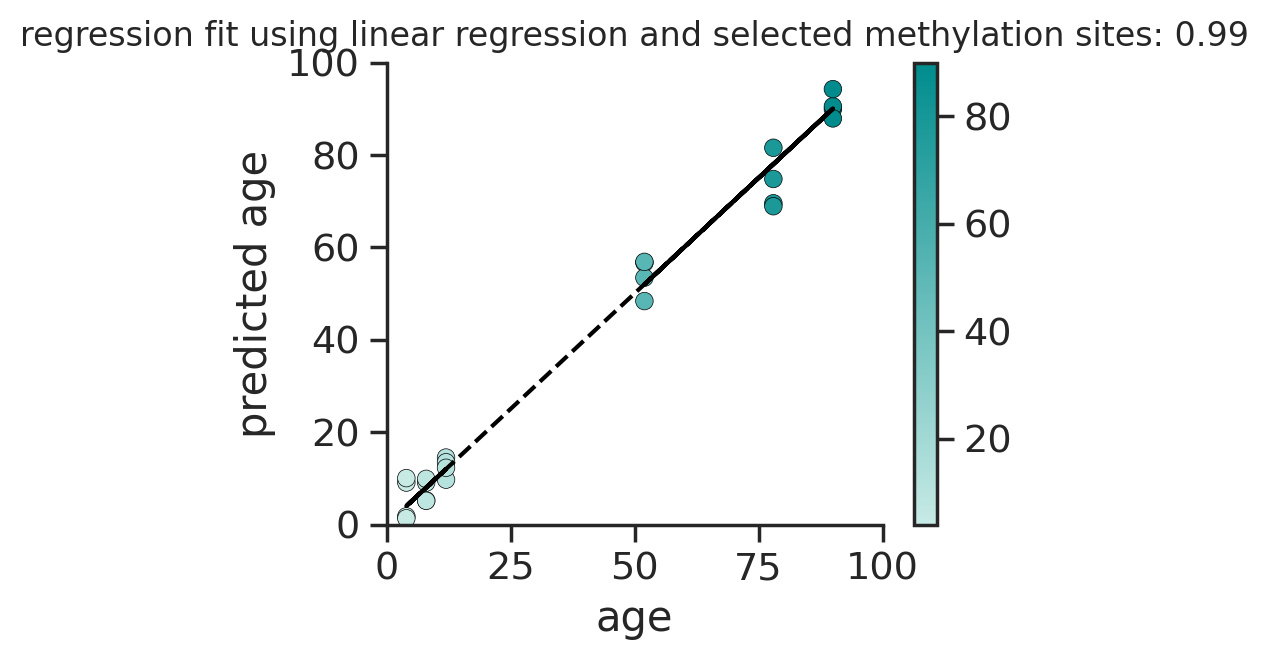

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y, y=y_pred, 
            s=40, 
            c=y, 
            edgecolor='black',
            linewidth=0.25,
            #norm='log',
            cmap=cmm)
sns.despine()
norm = plt.Normalize(y.min(), y.max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])
plt.ylim([0, 100])
plt.xlim([0, 100])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y, y, linestyle='--', color='black')
plt.title('regression fit using linear regression and selected methylation sites: ' + str(round(r2_age, 2)), fontsize=12)
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)